In [2]:
import numpy as np
import matplotlib.pyplot as plt
import circle_fit as cf
import pandas as pd  #import pandas
import seaborn as sns #import seaborn
from numpy import ones,vstack
from numpy.linalg import lstsq
import circle_fit as cf

In [18]:
################## ROP AXIAL [ft/hour]

def ROP_axial(RPM,WOB,Db,mi,Es):## units RPM - [Rotations per minute] / WOB - [kkgf] / Db - [inch] / Es - [specific energy, psi]
    
    Ab = np.pi*((Db)**2)/4 ## Area calculation based on diameter
  
    return 13.33*mi*RPM/(Db*(Es/(WOB*1000*2.20462)-1/Ab)) 

################## ROP Normal [ft/hour] ## NB temp1,temp2,temp3 calculated by the geometry of the well offset calculated from 'offsetfunction' - Do not change this values

def ROP_normal(offset, RPM, WOB, Db, mi, Es, Od, Id,temp1,temp2,temp3):## units RPM - [Rotations per minute] / WOB - [kkgf] / Db - [inch] / Es - [specific energy, psi]
    
    Ab = np.pi*((Db)**2)/4 ## Area calculation based on diameter
    
    alpha = 1 # constant to fit the DLS to adequate values
    
    beta = 0.15 # constant to fit the DLS to adequate values, it fits the reality - Lateral cutting is usually 30% of axial cutting
    
    E=30000000*(10**(9))/(0.145*10**6) # Elasticity modulus, considering steel
    
    Hoff = offset # do not mind - offset calculated from the 'offset function is a percentage from -100% until +100%'
    
    maxoffset=6*10**(-3) # Max offset of the tool [6mm]
    
    Hoffabs = Hoff*maxoffset # calculation of the physical offset considering the max offset and the percentage value

    OD = (Od*10**(-3)) # from mm to meter
    
    ID = (Id*10**(-3)) # from mm to meter
    
       
    #H = quatorzebis(temp1,temp2,temp3)[0]
    mlong=quatorzebis(temp1,temp2,temp3)[2] ############################################## Calculates the natural displacement
    H=0
    mshort=quatorzebis(temp1,temp2,temp3)[1]
    
    if np.isnan(H):
        h = 0
        
    else:
        h = np.abs(H)
    
    
    
    I_natural = np.pi*((OD**4-ID**4))/32 # inertia modulus
    
    I_OFF = np.pi*((OD**4-ID**4))/32 # inertia modulus
    
    D1=((2.700)**2-Hoffabs**2)**(1/2) # correction of the horizontal distance on the beam bending scheme
    
    D2=((0.500)**2-Hoffabs**2)**(1/2) # correction of the horizontal distance on the beam bending scheme
    
    #print(h)
    
    Fbit_Natural_abs  = (h*3*E*I_OFF)/(2.7*0.5**2)    # calculation of the force on the bit generated by the natural displacement
    
    Fbit_OFF  = (Hoffabs*3*E*I_OFF)/(D1*D2**2) # calculation of the force on the bit generated by the RSS offset
    
    
    if (np.arctan(mlong)>np.arctan(mshort)): ############################################## Calculates the signal of the the force ffrom the natural displacement
        Fbit_Natural= Fbit_Natural_abs
    elif (np.arctan(mlong)<np.arctan(mshort)):
        Fbit_Natural = -1*Fbit_Natural_abs
    else:
        Fbit_Natural = 0
    #print (Fbit_Natural)   
     
    FbitTOTAL = Fbit_OFF+Fbit_Natural 
        
        
    if (FbitTOTAL==0):  # Use to the ROP model from the SPE 24584 and the loop avois errors when Fbit total is equal to zero
        ROP_perpendicular = 0
    elif (FbitTOTAL>0):
        ROP_perpendicular  = ((13.33*mi*RPM*beta)/(Db*(((Es*alpha)/(0.220462*FbitTOTAL))-1/Ab)))
    else:
        ROP_perpendicular  = ((13.33*mi*RPM*beta)/(Db*(((Es*alpha)/(0.220462*FbitTOTAL))+1/Ab)))
            

    return ROP_perpendicular,Fbit_OFF,Fbit_Natural,FbitTOTAL

################## Calculation of H

def quatorzebis(temp1,temp2,temp3):# calculation of H
    
    temp=np.concatenate((temp1,temp2), axis=1) #tranforming the two points in one array - 3,2 meters behind
    
    temp=np.rot90(temp,2).T # rotating the array
    
    x_coords, y_coords = zip(*temp) #calculating the m and c
    
    A = vstack([x_coords,ones(len(x_coords))]).T #calculating the m and c
    
    m, c = lstsq(A, y_coords)[0] #calculating the m and c
    
    coef1 = m,c # calling a variable to define m and C [line is equal to y=m*x+c]
    
    ca=temp[0] # ca is the evaluated point
    
    xo=ca[0] # xo is collecting the x value of the analysed point
    
    yo=ca[1] # yo is collecting the y value of the analysed point
    
    mo=coef1[0] #mo is iqual to m of the created line
    
    co=coef1[1] #co is equal to the c of the created line
    
    delta=(-2*xo+2*co*mo-2*mo*yo)**2-4*(mo**2+1)*(xo**2+co**2-2*yo*co+yo**2-0.25*3.28*3.28)# calculating the delta of the baskara formula (sqrt((X point on the bit - X point 50 cm behind from the bit)**2 + (Y point on the bit - Y point 50 cm behind from the bit)**2)) = 0.5meters)
    
    # on the created line, we are going 50 cm back because this is the distance from the bit to the RSS system
    
    Xp=(-1*(-2*xo+2*co*mo-2*mo*yo)-delta**0.5)/(2*(mo**2+1))# calculating Xp 50cm behind ( the sign - is used, hence this point is behing the bit)
    
    Yp=mo*Xp+co # calculating Yp 50cm behind 
    
    temp01=np.concatenate((temp3, temp2), axis=1) # doing the same process for 50 cm behind the bit 
    
    temp01=np.rot90(temp01,2).T #tranforming the two points in one array
    
    x_coords1, y_coords1 = zip(*temp01) #calculating the m and c
    
    A1 = vstack([x_coords1,ones(len(x_coords1))]).T #calculating the m and c
    
    m1, c1 = lstsq(A1, y_coords1)[0] #calculating the m and c
    
    coef2 = m1,c1 # calling a variable to define m and C [line is equal to y=m*x+c]
    
    ca1=temp01[0] # ca1 is the evaluated point, ca1=ca
    
    xo1=ca1[0] # xo1 is collecting the x value of the analysed point, xo=xo1
    
    yo1=ca1[1] # yo1 is collecting the y value of the analysed point, yo=yo1
    
    mo1=coef2[0] #mo1 is iqual to m of the created line, mo is different to mo1
    
    co1=coef2[1] #co1 is iqual to c of the created line, co is different to co1
    
    delta1=(-2*xo1+2*co1*mo1-2*mo1*yo1)**2-4*(mo1**2+1)*(xo1**2+co1**2-2*yo1*co1+yo1**2-0.25*3.28*3.28)# calculating the delta of the baskara formula (sqrt((X point on the bit - X point 50 cm behind from the bit)**2 + (Y point on the bit - Y point 50 cm behind from the bit)**2)) = 0.5meters)
    
    Xp1=(-1*(-2*xo1+2*co1*mo1-2*mo1*yo1)-delta1**0.5)/(2*(mo1**2+1))# calculating Xp 50cm behind (just the sign - is used, hence this point is behing the bit)
    
    Yp1=mo1*Xp1+co1 # calculating Yp 50cm behind 
    
    


    H=(((np.abs(Xp1)-np.abs(Xp))**2+(np.abs(Yp1)-np.abs(Yp))**2)**0.5)*0.3048#calculating the distance between the to points 50 cm behind of the bit
    

    
    return  H,mo1,mo # in meter


            

    

################################ CONTROLER Calculation ( to easier undertanding i advice to see the 'caetano' calculation on the end of the code)


def offsetfunction(target_inclination,maxoff):
    
    
    
    dinc = (np.abs(target_inclination)*np.pi/180 - np.abs(log[t,2]))# distance between the desired inclination and the inclination where the bit is in a determined time t

      
    if (np.abs(dinc)>=0.65*np.pi/180): # if the diference between the target inclination and the moment inclination is greater than 0,65, the offset regarding inclination should be 100%
        if (target_inclination>log[t,2]*180/np.pi): 
            offset = +1*maxoff    ## If the inclination that is being analysed is lower than the target inclination, the offset will be positive
        else:
            offset = -1*maxoff    ## If the inclination that is being analysed is greater than the target inclination, the offset will be negative
       
    elif (np.abs(dinc)<0.65*np.pi/180): # if the diference between the target inclination and the moment inclination is greater than 0,65, the offset regarding inclination should be 1,5* dinc
        if (target_inclination>log[t,2]*180/np.pi):
            offset = 1*np.abs(dinc)*1*maxoff # the same signal logic from the before 
        else:
            offset = -1*np.abs(dinc)*1*maxoff
        
            

    return offset

In [19]:
## defining for how long we will drill and delta T, the T is the number of timesteps and the delta 5 is how many seconds a time step values

t_max = 100000
t100 = t_max/100

for i in range(100):
    print ("_", end="")

deltaT = 5
######################## Constant data defining variables for the ROP model

offset = 0 # initial values required by python

mi=0.23
RPM = 143.44375 # rotations per second - units defined on the ROP function
WOB = 7.124417 # kkgf
DLS=0
Db = 12.25 # inches
ODout = 190 # mm
IDout = 175 # mm
Od = 80 # mm
Id = 37 # mm
Es = 14633.401276 # psi 

########################### target points
# defined target points. 

#First target points

TargetInc1=90

#Second target points

TargetInc2=0

#Third target points

TargetInc3=0

## it is possible to add target points

## defining the inicial values
t = 1
log = np.zeros((t_max,10))

#0: MD
#1: error
#2: inc
#3: Horizontal
#4: TVD
#5: offset
#6: DSL

current_depth = 0

while current_depth < 10.496+1:
    
    
    log[t,0] = log[t-1,0]+ROP_axial(RPM,WOB,Db,mi,Es)*deltaT/3600 # as we are drilling vertically the axial ROP will just be composed by the axial ROP
    
    log[t,1] = 0 #(do not care about this variable)
    
    log[t,2] = 0 # Inclination is zero on the initial point
    
    log[t,3] = log[t,0] # when we are vertical, the TVD is equal to the MD    
    
    log[t,4] =  0# defined as zero previouslly, no offset in vertical wells
    
    log[t,5] = offset # defined as zero previouslly, no offset in vertical wells
    
    log[t,6] = DLS  # defined as zero previouslly, no DSL in vertical wells
    log[t,7] =0
    log[t,8] =0
    log[t,9] =0    

 
    current_depth = log[t,0]
    #print(current_depth)
    t += 1
    

## this is the calculation of the geometry behind the bit
while t < t_max:
        
    j = t-2
    while True:
        distance = log[t-1,0] - log[j,0] # uses the Measured deepth difference
        if distance >= 10.496: # for every point analysed, we search which point is in 3,2 meters behind and collect the coordinates
            
            break
        else:
            j = j-1
    
    temp_data1 = [[log[j,4],log[j,3]]]# coordenates of 3.2 behind of the point regarding TVD x Horizontal displacement
    temp_data2 = [[log[t-1,4],log[t-1,3]]]# coordenates of the point TVD x Horizontal displacement
    temp_data1 = np.rot90(temp_data1,1)
    temp_data2 = np.rot90(temp_data2,1) # do not mind... python logistics

    
    g = t-2
    while True:
        distance = log[t-1,0] - log[g,0] # uses the Measured deepth difference
        if distance >= 1.64:# for every point analysed, we search which point is in 0,5 meters behind and collect the coordinates
            
            break
        else:
            g = g-1
    
    temp_data3 = [[log[g,4],log[g,3]]] # coordenates of 0.5 behind of the point regarding TVD x Horizontal displacement
    temp_data4 = [[log[t-1,4],log[t-1,3]]] # coordenates of the point regarding TVD x Horizontal displacement
    temp_data3 = np.rot90(temp_data3,1)
    temp_data4 = np.rot90(temp_data4,1)
    

    
    
    ROP_n_inc = ROP_normal(offset, RPM, WOB, Db, mi, Es, Od, Id,temp_data1,temp_data2,temp_data3)[0] # calculation of ROP's base on the previous functions
    ROP_a = ROP_axial(RPM,WOB,Db,mi,Es)

#Reminder of the meaning of the logs.... Now we will calculate its variations once we are not anymore on the initial points   

#0: MD
#1: error
#2: inc
#3: TVD
#4: Horizontal
#5: offset
#6: DSL
    
 
    log[t,0] = log[t-1,0] + np.sqrt(ROP_n_inc**2 + ROP_a**2)*deltaT/3600 # The MD considers the resultant ROP from the 3 existing ROPs
    
    log[t,1] = 0 # do not mind thgis one
    
    log[t,2] = log[t-1,2] + np.arctan(ROP_n_inc/ROP_a)*deltaT/3600 # the new inclination will be the previous inclination plus the increase caused by the ROP Normal generated for the offset_inc
        
    log[t,3] = log[t-1,3] + np.cos(log[t,2])*np.sqrt(ROP_n_inc**2 + ROP_a**2)*deltaT/3600 # It uses the resultant of the ROP regarding inclination 
    
    log[t,4] = log[t-1,4] + np.sin(log[t,2])*np.sqrt(ROP_n_inc**2 + ROP_a**2)*deltaT/3600 # It uses the resultant of the ROP regarding inclination 
    
    log[t,5] = offset
    
    log[t,6] = ((np.abs(log[t,2]))-(np.abs(log[t-1,2])))*180/((np.abs(log[t,0])-np.abs(log[t-1,0]))*np.pi)*100 #DLS
    
    log[t,7] =ROP_normal(offset, RPM, WOB, Db, mi, Es, Od, Id,temp_data1,temp_data2,temp_data3)[1]
    log[t,8] =ROP_normal(offset, RPM, WOB, Db, mi, Es, Od, Id,temp_data1,temp_data2,temp_data3)[2]
    log[t,9] =ROP_normal(offset, RPM, WOB, Db, mi, Es, Od, Id,temp_data1,temp_data2,temp_data3)[3]
    
    

    
    maxoff=1 ## definition of the max offset desired by the customer, there are some companies that do not wish to have big DLS, hence we must reduce the max offset here (values between 0 and 1)
    
# first Target point kick off [TVD], note that the values have been defined before
    
    if log[t,0] > 150:
        #offset=1
        offset = offsetfunction(TargetInc1,maxoff)
        
# Second Target point kick off [TVD], note that the values have been defined before 

    if log[t,0] > 350:
        #offset=-1
        offset = offsetfunction(TargetInc2,maxoff)  
        
# Third Target point kick off [TVD], note that the values have been defined before        
        
    if log[t,0] > 4000:
        #offset=0
        offset = offsetfunction(TargetInc3,maxoff)  
        

    #print (offset)
    t = t+1
    
    if t%t100 == 0:
        print ('.', end="")

____________________________________________________________________________________________________

C:\Users\Bruker\Anaconda3\lib\site-packages\ipykernel_launcher.py:93: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
C:\Users\Bruker\Anaconda3\lib\site-packages\ipykernel_launcher.py:111: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Bruker\Anaconda3\lib\site-packages\ipykernel_launcher.py:123: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


....................................................................................................

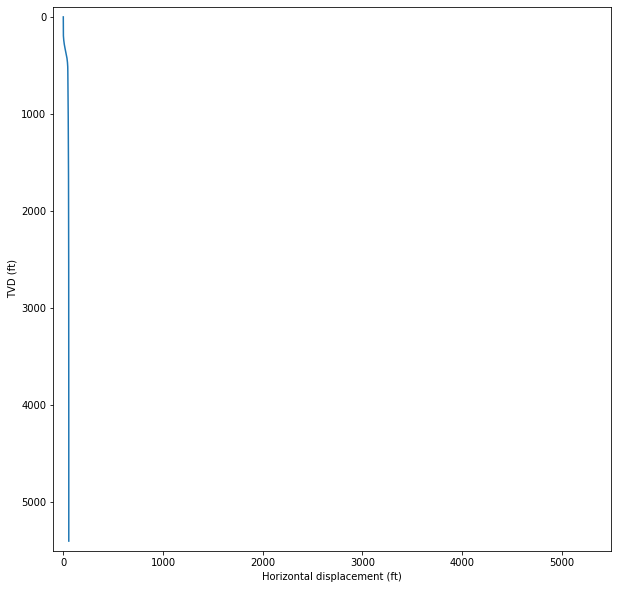

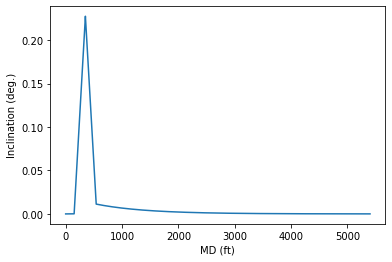

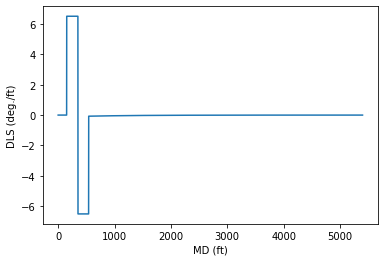

Text(0, 0.5, 'Offset')

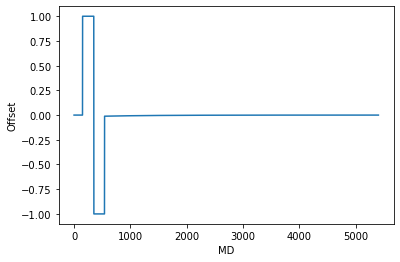

In [20]:
####################################  PLOT 2D


plt.figure(figsize=(10,10))

plt.plot(log[:,4],log[:,3])

xy0 = np.min( [ np.min(log[:,3])  ,    np.min(log[:,4])  ] ) - 100
xy1 = np.max( [ np.max(log[:,3])  ,    np.max(log[:,4])  ] ) +100


plt.xlim((xy0,xy1))
plt.ylim((xy1,xy0))

plt.xlabel('Horizontal displacement (ft)')
plt.ylabel('TVD (ft)')


plt.show()
plt.plot(log[:,0],log[:,2])
plt.xlabel('MD (ft)')
plt.ylabel('Inclination (deg.)')
#plt.xlim((0,1000))
#plt.xlim((0,1500))

plt.show()
plt.plot(log[:,0],log[:,6])
#plt.xlim((0,1000))
#plt.ylim((-15,15))
plt.xlabel('MD (ft)')
plt.ylabel('DLS (deg./ft)')

#plt.xlim((0,1500))


plt.show()
plt.plot(log[:,0],log[:,5])
plt.xlabel('MD')
plt.ylabel('Offset')
#plt.xlim((1000,1008))
#plt.xlim((0,1500))



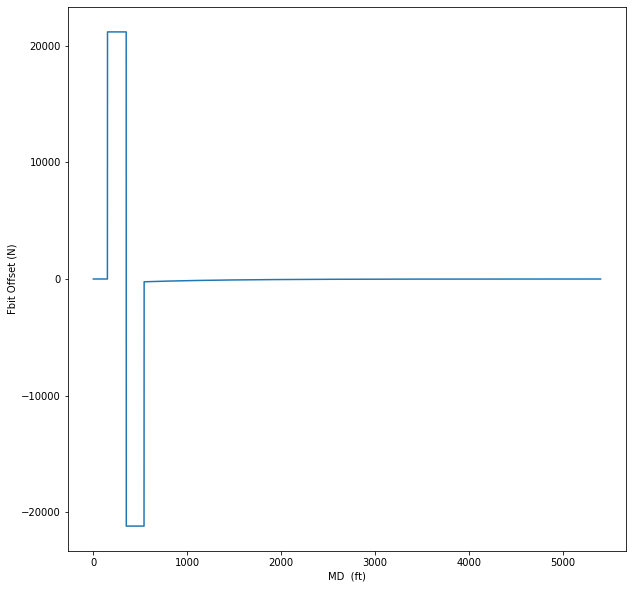

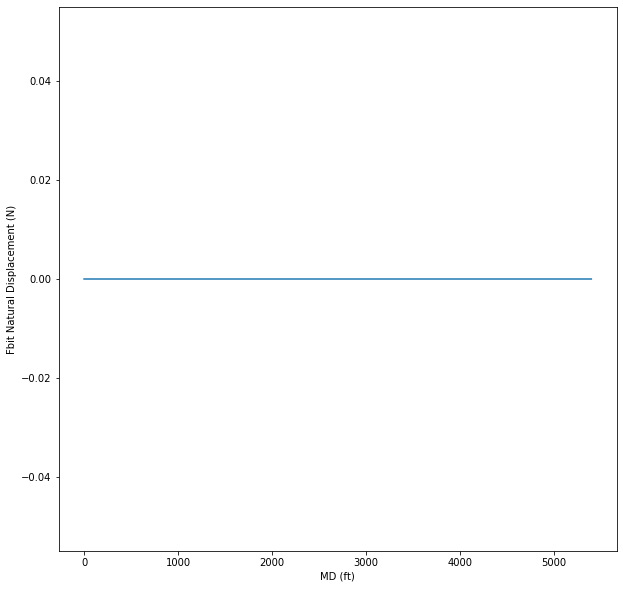

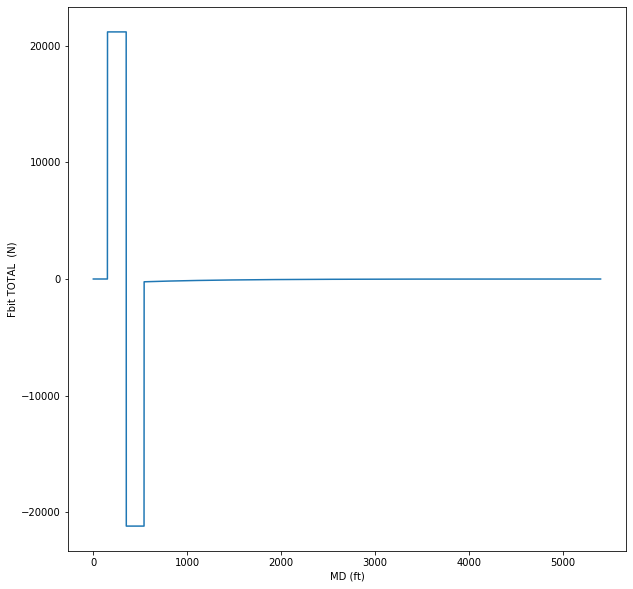

In [21]:
plt.figure(figsize=(10,10))

plt.plot(log[:,0],log[:,7])
#plt.xlim((1640,1660))
#plt.xlim((3.14325,3.151))
#plt.ylim((-20000,50000))
#plt.ylim((-2000,2000))
#plt.xlim((999,1008))
#plt.xlim((0,1000))
plt.xlabel('MD  (ft)')
plt.ylabel('Fbit Offset (N)')
plt.show()


plt.figure(figsize=(10,10))

plt.plot(log[:,0],log[:,8])
#plt.ylim((-20000,20000))
#plt.xlim((1640,1660))
#plt.ylim((0.003,000.5))
#plt.xlim((0,1000))
plt.xlabel('MD (ft)')
plt.ylabel('Fbit Natural Displacement (N)')
#plt.ylim((-20000,50000))
plt.show()

plt.figure(figsize=(10,10))

plt.plot(log[:,0],log[:,9])
#plt.xlim((1999,2010))
#plt.ylim((-20000,50000))
#plt.ylim((-50000,50000))
#plt.xlim((1640,1660))
#plt.ylim((0.003,000.5))
#plt.xlim((0,1000))
#plt.xlim((999,1008))
plt.xlabel('MD (ft)')
plt.ylabel('Fbit TOTAL  (N)')
plt.show()
